In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt

## Distancias

In [3]:
def Dist_Euclidea(x_i, x_r):

        Dist_Euclidea = ( ( x_i - x_r )**2 ).sum()

        Dist_Euclidea = np.sqrt(Dist_Euclidea)

        return Dist_Euclidea

In [4]:
def Matrix_Dist_Euclidea(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Euclidea(Data[i,:] , Data[r,:])   

                      
    return M 

In [5]:
def Dist_Minkowski(x_i, x_r, q):

    Dist_Minkowski = ( ( ( abs( x_i - x_r) )**q ).sum() )**(1/q)

    return Dist_Minkowski

In [6]:
def Matrix_Dist_Minkowski(Data, q):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Minkowski(Data[i,:] , Data[r,:], q)   

                      
    return M 

In [7]:
def Dist_Canberra(x_i, x_r):

    numerator =  abs( x_i - x_r )

    denominator =  ( abs(x_i) + abs(x_r) )
       
    numerator=np.array([numerator], dtype=float)

    denominator=np.array([denominator], dtype=float)

    # The following code is to eliminate zero division problems

    Dist_Canberra = ( np.divide( numerator , denominator , out=np.zeros_like(numerator), where=denominator!=0) ).sum() 

    return Dist_Canberra

In [8]:
def Matrix_Dist_Canberra(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Canberra(Data[i,:] , Data[r,:])   

                      
    return M 

In [9]:
def Dist_Mahalanobis_2(x_i, x_r, S_inv):  # Más eficiente que la anterior

    # All the columns of Data must be type = 'float' or 'int' (specially not 'object'), in other case we will find 
    # dimensional problems when Python compute   x @ S_inv @ x.T

    x = (x_i - x_r)
    
    # x = np.array([x]) 
    
    # En este caso este paso no será necesario por el tipo de estructura Python (una lista) que va a ser un medoid en el
    # algoritmo que a continuación definiremos. De hecho si este paso no se suprimer salta un error al usar la distancia
    # de Mahalanobis, puesto que la operacion x @ S_inv @ x.T no está bien definida.

    Dist_Maha = np.sqrt( x @ S_inv @ x.T )  # x @ S_inv @ x.T = np.matmul( np.matmul(x , S_inv) , x.T )

    Dist_Maha = float(Dist_Maha)

    return Dist_Maha

In [10]:
def Dist_Mahalanobis_3(x, S_inv):  # Más eficiente que la anterior

    # All the columns of Data must be type = 'float' or 'int' (specially not 'object'), in other case we will find 
    # dimensional problems when Python compute   x @ S_inv @ x.T

    # x = (x_i - x_r)

    # x = np.array([x]) # necessary step to transpose a 1D array

    Dist_Maha = np.sqrt( x @ S_inv @ x.T )  # x @ S_inv @ x.T = np.matmul( np.matmul(x , S_inv) , x.T )

    Dist_Maha = float(Dist_Maha)

    return Dist_Maha

In [11]:
def Matrix_Dist_Mahalanobis_3(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    S_inv=np.linalg.inv( np.cov(Data , rowvar=False) )

   
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Mahalanobis_3(x = np.array([Data[i,:] - Data[r,:]]) , S_inv=S_inv ) 

                      
    return M 

In [12]:
def a_b_c_d_Matrix(Data):

    X = Data

    a = X @ X.T

    n = X.shape[0]

    p = X.shape[1]

    ones_matrix = np.ones((n, p)) 

    b = (ones_matrix - X) @ X.T

    c = b.T

    d = (ones_matrix - X) @ (ones_matrix - X).T

    return a , b , c , d , p

In [13]:
def alpha(x_i, x_r):

    alpha = sum(x_i == x_r)

    return(alpha)

In [14]:
def Matrix_Gower_Similarity(Data, p1, p2, p3 ):

    # Data tiene que ser un numpy array tal que:
    # las primeras p1 tiene que ser variables cuantitativas, 
    # las siguientes p2 binarias y las restantes p3 multicales

    # Si Data no contiene variables cuantitativas --> p1=0
    # Si Data no contiene variables binarias --> p2=0
    # Si Data no contiene variables multiclase --> p3=0

    n = len(Data)

    M =  np.empty((n , n))

############################################################
    
    G_vector = np.repeat(0.5, p1)

    for k in range(0, p1):

        G_vector[k] = Data[:,k].max() - Data[:,k].min()

############################################################
   
    ones = np.repeat(1, p1)

    Quant_Data = Data[: , 0:p1]

    Binary_Data = Data[: , (p1):(p1+p2)]

    Multiple_Data = Data[: , (p1+p2):(p1+p2+p3) ]

############################################################

    a, b, c, d, p = a_b_c_d_Matrix(Binary_Data)

############################################################

    for i in range(0, n):

         for r in range(0, n):

            if i > r :
               
                 M[i,r] = 0
            
            elif i == r :
               
                 M[i,r] = 1
            
            else :

                # Calculo de la distancia de Gower entre las observaciones x_i y x_r

                numerator_part_1 = ( ones - ( abs(Quant_Data[i,:] - Quant_Data[r,:]) / G_vector ) ).sum() 

                numerator_part_2 = a[i,r] + alpha(Multiple_Data[i,:], Multiple_Data[r,:])

                numerator = numerator_part_1 + numerator_part_2
                

                if p1 + (p2 - d[i,r]) + p3 == 0:

                    M[i,r] = 0

                else:
                    
                    denominator = p1 + (p2 - d[i,r]) + p3

                    M[i,r] = numerator / denominator
                      
   
    return M  

In [15]:
def Matrix_Gower_Distance(Data, p1, p2, p3 ):

    M = Matrix_Gower_Similarity(Data, p1, p2, p3)

    M = M + M.T - np.diag(np.repeat(1 , len(M)), k=0)

    M = np.sqrt( 1 - M )

    return M

## KNN-clasificacion programado de cero

In [16]:
Data = pd.read_csv('House_Price_Regression.csv')

Data_Mixed = Data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2', 'balcony_recode', 'private_garden_recode', 'quality_recode']]

Data_Mixed.head()

,latitude,longitude,price,size_in_m_2,balcony_recode,private_garden_recode,quality_recode
0,25.113208,55.138932,2700000,100.242337,1.0,0.0,2.0
1,25.106809,55.151201,2850000,146.972546,1.0,0.0,2.0
2,25.063302,55.137728,1150000,181.253753,1.0,0.0,2.0
3,25.227295,55.341761,2850000,187.664060,1.0,0.0,1.0
4,25.114275,55.139764,1729200,47.101821,0.0,0.0,2.0


In [17]:

Data_Mixed_train = Data_Mixed.sample(frac=0.8, replace=False, weights=None, random_state=123, axis=None, ignore_index=False)

Data_Mixed_new =  Data_Mixed.drop( Data_Mixed_train.index , )

In [18]:
## TRAIN DATA (Datos dispobles --> se usan para entrenar el modelo)

X_train = Data_Mixed_train.loc[: , Data_Mixed_train.columns != 'quality_recode']
Y_train = Data_Mixed_train.loc[: , 'quality_recode']

## NEW DATA (Nuevos datos de los predictores)

X_new = Data_Mixed_new.loc[: , Data_Mixed_new.columns != 'quality_recode']

# En la práctica real no se tienen datos sobre la respuesta asociado a las nuevas obsrvaciones de los predictores
# Eso es justo lo que se quiere predecir.
# Pero en este ejemplo al usar como "nuevos" datos una parte del data set original, si que tenemos esa información.

Y_new = Data_Mixed_new.loc[: , 'quality_recode'] 


In [19]:
X_train.head()

,latitude,longitude,price,size_in_m_2,balcony_recode,private_garden_recode
382,25.196489,55.272126,15800000,488.019459,0.0,1.0
732,25.107984,55.244923,1700000,138.704179,0.0,0.0
1888,25.071504,55.128579,1300000,171.220229,1.0,0.0
679,25.054336,55.203423,999000,116.035847,1.0,1.0
1004,25.087251,55.145574,2990000,162.208638,1.0,0.0


In [20]:
X_new.head()

,latitude,longitude,price,size_in_m_2,balcony_recode,private_garden_recode
1,25.106809,55.151201,2850000,146.972546,1.0,0.0
2,25.063302,55.137728,1150000,181.253753,1.0,0.0
3,25.227295,55.341761,2850000,187.664060,1.0,0.0
8,25.106668,55.149275,2100000,203.085958,0.0,0.0
16,25.132021,55.151405,3499000,151.710599,1.0,0.0


In [21]:
X = pd.concat([X_train , X_new])
X.head()

,latitude,longitude,price,size_in_m_2,balcony_recode,private_garden_recode
382,25.196489,55.272126,15800000,488.019459,0.0,1.0
732,25.107984,55.244923,1700000,138.704179,0.0,0.0
1888,25.071504,55.128579,1300000,171.220229,1.0,0.0
679,25.054336,55.203423,999000,116.035847,1.0,1.0
1004,25.087251,55.145574,2990000,162.208638,1.0,0.0


In [22]:
Y_train.head()

382     2.0
732     1.0
1888    2.0
679     0.0
1004    2.0
Name: quality_recode, dtype: float64

In [23]:
Y_new.head()

1     2.0
2     2.0
3     1.0
8     1.0
16    2.0
Name: quality_recode, dtype: float64

In [24]:
M_Gower = Matrix_Gower_Distance(Data=X.to_numpy(), p1=4, p2=2, p3=0)
M_Gower

array([[0.        , 0.64817837, 0.76118906, ..., 0.70588672, 0.62389777,
        0.76544317],
       [0.64817837, 0.        , 0.5387377 , ..., 0.51390107, 0.61030246,
        0.53192923],
       [0.76118906, 0.5387377 , 0.        , ..., 0.38695255, 0.48555238,
        0.20821652],
       ...,
       [0.70588672, 0.51390107, 0.38695255, ..., 0.        , 0.477898  ,
        0.33432523],
       [0.62389777, 0.61030246, 0.48555238, ..., 0.477898  , 0.        ,
        0.45160134],
       [0.76544317, 0.53192923, 0.20821652, ..., 0.33432523, 0.45160134,
        0.        ]])

In [25]:
M_Gower_new_data = M_Gower[ len(X_train):len(X) , 0:len(X_train) ]  

# Nos quedamos con las filas de la 1524 a la 1904 , que son las correspondientes a las nuevas observaciones de los predictores.
# Nos queamos con las columnas de la 0 a la 1524, que son las correspondientes a las observaciones de train de los predictores.

# 'M_new_data' contiene las distancias (de Gower) entre las nuevas observaciones de los predictores y las de entrenamiento.

# Su fila i-esima contiene las distancias entre la i-esima nueva observacion de los predictores y las observaciones de entrenamiento.

In [26]:
M_Gower_new_data.shape

(381, 1524)

In [52]:
class KNNClassification:
    
    def __init__(self, k, X_train, Y_train, distance_matrix_new_data):

        self.k = k
        
        self.X_train = X_train
        
        self.Y_train = Y_train
        
        self.distance_matrix_new_data = distance_matrix_new_data
        
        self.predictions = None
    

    def predict(self):

        Y_predict_x_new_i_LIST = []

        for i in range(0, len(self.distance_matrix_new_data)):

            distancias_x_new_i = pd.DataFrame({'id_x_train': self.X_train.index, 'distancias': self.distance_matrix_new_data[i,:]})

            distancias_x_new_i_sort = distancias_x_new_i.sort_values(by=["distancias"]).reset_index(drop=True)

            knn_x_new_i = distancias_x_new_i_sort.iloc[0:self.k, 0]

           
            categorias_knn_x_new_i = []

            for j in knn_x_new_i :

                categorias_knn_x_new_i.append(self.Y_train[j])


            unique, counts = np.unique(categorias_knn_x_new_i , return_counts=True)

            unique_Y , counts_Y = np.unique(self.Y_train , return_counts=True)


            if len(unique) == len(unique_Y) :

                proporciones_categorias_knn_x_new_i = pd.DataFrame({'prop_categoria': counts/self.k, 'categoria': unique_Y })

            elif len(unique) < len(unique_Y) :

                proporciones_categorias_knn_x_new_i = pd.DataFrame({'prop_categoria': counts/self.k, 'categoria': unique })


            Y_predict_x_new_i = proporciones_categorias_knn_x_new_i.sort_values(by=["prop_categoria"], ascending=False).iloc[0 , :]['categoria']


            Y_predict_x_new_i_LIST.append(Y_predict_x_new_i)


        self.df_predictions = pd.DataFrame({'id_x_new':range(0, len(self.distance_matrix_new_data)) , 'Y_predict': Y_predict_x_new_i_LIST})

        self.predictions = self.df_predictions['Y_predict']
        


In [53]:
KNNClassification_init = KNNClassification(k=10, X_train=X_train, Y_train=Y_train, distance_matrix_new_data=M_Gower_new_data)

KNNClassification_init.predict()

In [55]:
KNNClassification_init.df_predictions

,id_x_new,Y_predict
0,0,2.0
1,1,2.0
2,2,2.0
3,3,1.0
4,4,2.0
...,...,...
376,376,2.0
377,377,2.0
378,378,2.0
379,379,0.0


In [56]:
KNNClassification_init.predictions

0      2.0
1      2.0
2      2.0
3      1.0
4      2.0
      ... 
376    2.0
377    2.0
378    2.0
379    0.0
380    2.0
Name: Y_predict, Length: 381, dtype: float64

In [57]:
TA = sum( KNNClassification_init.predictions == Y_new.reset_index().quality_recode ) / len(Y_new)
TA

0.7611548556430446

In [58]:
M_Euclidea = Matrix_Dist_Euclidea(Data=X.to_numpy())

M_Euclidea  = M_Euclidea + M_Euclidea.T

M_Euclidea_new_data = M_Euclidea[ len(X_train):len(X) , 0:len(X_train) ]  

In [59]:
KNNClassification_init = KNNClassification(k=10, X_train=X_train, Y_train=Y_train, distance_matrix_new_data=M_Euclidea_new_data)

KNNClassification_init.predict()

In [60]:
KNNClassification_init.df_predictions

,id_x_new,Y_predict
0,0,2.0
1,1,1.0
2,2,2.0
3,3,1.0
4,4,2.0
...,...,...
376,376,2.0
377,377,2.0
378,378,1.0
379,379,2.0


In [61]:
TA = sum( KNNClassification_init.predictions == Y_new.reset_index().quality_recode ) / len(Y_new)
TA

0.5958005249343832

In [40]:
def KNN_classification(Distance_Matrix_New_Data , k, X_train, Y_train ) :

    # k es el hiper-parametro del algoritmo KNN.

    # 'Distance_Matrix_New_Data' debe contenere las distancias entre las nuevas observaciones de los predictores y las observaciones de train de los predictores.

    # Su fila i-esima debe contener las distancias entre la i-esima nueva observacion de los predictores y las observaciones de train de los predictores.


    Y_predict_x_new_i_LIST = []

    for i in range(0, len(Distance_Matrix_New_Data)):

        distancias_x_new_i = pd.DataFrame({'id_x_train': X_train.index  , 'distancias': Distance_Matrix_New_Data[i,:]})

        distancias_x_new_i_sort = distancias_x_new_i.sort_values(by=["distancias"]).reset_index(drop=True)

        knn_x_new_i = distancias_x_new_i_sort.iloc[0:k , :]

        categorias_knn_x_new_i = []

        
        for j in knn_x_new_i.iloc[:,0]:

            categorias_knn_x_new_i.append(Y_train[j])

    
        unique, counts = np.unique(categorias_knn_x_new_i , return_counts=True)

        unique_Y , counts_Y = np.unique(Y_train , return_counts=True)

    
        if len(unique) == len(unique_Y) :

            proporciones_categorias_knn_x_new_i = pd.DataFrame({'prop_categoria': counts/k, 'categoria': unique_Y })
        
        elif len(unique) < len(unique_Y) :

            proporciones_categorias_knn_x_new_i = pd.DataFrame({'prop_categoria': counts/k, 'categoria': unique })


        Y_predict_x_new_i = proporciones_categorias_knn_x_new_i.sort_values(by=["prop_categoria"], ascending=False).iloc[0,:]['categoria']


        Y_predict_x_new_i_LIST.append(Y_predict_x_new_i)

    
    df_predictions = pd.DataFrame({'id_x_new':range(0, len(Distance_Matrix_New_Data)) , 'Y_predict': Y_predict_x_new_i_LIST})

    return df_predictions

In [41]:
df_predictions = KNN_classification(Distance_Matrix_New_Data = M_Gower_new_data , k=10, X_train=X_train, Y_train=Y_train)

In [42]:
df_predictions

,id_x_new,Y_predict
0,0,2.0
1,1,2.0
2,2,2.0
3,3,1.0
4,4,2.0
...,...,...
376,376,2.0
377,377,2.0
378,378,2.0
379,379,0.0


In [30]:
Y_new.reset_index().quality_recode

0      2.0
1      2.0
2      1.0
3      1.0
4      2.0
      ... 
376    0.0
377    2.0
378    2.0
379    2.0
380    0.0
Name: quality_recode, Length: 381, dtype: float64

In [43]:
TA = sum( df_predictions.Y_predict == Y_new.reset_index().quality_recode ) / len(Y_new)

TA

0.7611548556430446

In [32]:
TE = 1 - TA
TE

0.23884514435695536

In [37]:
M_Euclidea = Matrix_Dist_Euclidea(Data=X.to_numpy())

M_Euclidea  = M_Euclidea + M_Euclidea.T

M_Euclidea_new_data = M_Euclidea[ len(X_train):len(X) , 0:len(X_train) ]  

In [38]:
df_predictions = KNN_classification(Distance_Matrix_New_Data = M_Euclidea_new_data , k=10, X_train=X_train, Y_train=Y_train)

In [39]:
df_predictions

,id_x_new,Y_predict
0,0,2.0
1,1,1.0
2,2,2.0
3,3,1.0
4,4,2.0
...,...,...
376,376,2.0
377,377,2.0
378,378,1.0
379,379,2.0


In [40]:
TA = sum( df_predictions.Y_predict == Y_new.reset_index().quality_recode ) / len(Y_new)
TA

0.5958005249343832

In [41]:
TE = 1 - TA
TE

0.4041994750656168

## KNN-clasificación con `sklearn`

In [42]:
import sklearn

from sklearn.neighbors import NearestNeighbors

In [43]:
# sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None) 

In [44]:
knn_classification = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10 ,  p=2, metric='minkowski')

In [45]:
knn_classification.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=10)

In [46]:
knn_classification.predict( X_new ) 

array([2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 2., 2., 3., 1., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1., 2.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 3., 3.,
       2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 3., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 3.,
       2., 2., 2., 2., 2., 2., 2., 3., 2., 1., 2., 1., 1., 2., 2., 2., 1.,
       2., 2., 2., 2., 2.

In [47]:
TA = sum( knn_classification.predict( X_new ) == Y_new.reset_index().quality_recode ) / len(Y_new)
TA

0.5958005249343832

In [48]:
knn_classification = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10 , p=1,  metric='minkowski')

knn_classification.fit(X_train, Y_train)

TA = sum( knn_classification.predict( X_new )  == Y_new.reset_index().quality_recode ) / len(Y_new)
TA

0.5931758530183727

In [49]:
knn_classification = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10 ,   metric='cosine')

knn_classification.fit(X_train, Y_train)

TA = sum( knn_classification.predict( X_new )  == Y_new.reset_index().quality_recode ) / len(Y_new)
TA

0.6115485564304461

## KNN-regresion programado de cero

In [25]:
class KNNRegression :
    
    def __init__(self, k, X_train, Y_train, distance_matrix_new_data):

        self.k = k
        
        self.X_train = X_train
        
        self.Y_train = Y_train
        
        self.distance_matrix_new_data = distance_matrix_new_data
        
        self.predictions = None
    

    def predict(self):

        Y_predict_x_new_i_LIST = []

        for i in range(0, len(self.distance_matrix_new_data)):

            distancias_x_new_i = pd.DataFrame({'id_x_train': self.X_train.index, 'distancias': self.distance_matrix_new_data[i,:]})

            distancias_x_new_i_sort = distancias_x_new_i.sort_values(by=["distancias"]).reset_index(drop=True)

            knn_x_new_i = distancias_x_new_i_sort.iloc[0:self.k, 0]

           
            Y_values_knn_x_new_i = []

            for j in knn_x_new_i :

                Y_values_knn_x_new_i.append(self.Y_train[j])

            
            Y_predict_x_new_i = sum(Y_values_knn_x_new_i)/self.k    

            Y_predict_x_new_i_LIST.append(Y_predict_x_new_i)


        self.df_predictions = pd.DataFrame({'id_x_new':range(0, len(self.distance_matrix_new_data)) , 'Y_predict': Y_predict_x_new_i_LIST})

        self.predictions = self.df_predictions['Y_predict']
        


In [18]:
Data = pd.read_csv('House_Price_Regression.csv')

Data_Mixed = Data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2', 'balcony_recode', 'private_garden_recode', 'quality_recode']]

Data_Mixed.head()

,latitude,longitude,price,size_in_m_2,balcony_recode,private_garden_recode,quality_recode
0,25.113208,55.138932,2700000,100.242337,1.0,0.0,2.0
1,25.106809,55.151201,2850000,146.972546,1.0,0.0,2.0
2,25.063302,55.137728,1150000,181.253753,1.0,0.0,2.0
3,25.227295,55.341761,2850000,187.664060,1.0,0.0,1.0
4,25.114275,55.139764,1729200,47.101821,0.0,0.0,2.0


In [19]:
Data_Mixed_train = Data_Mixed.sample(frac=0.8, replace=False, weights=None, random_state=123, axis=None, ignore_index=False)

Data_Mixed_new =  Data_Mixed.drop( Data_Mixed_train.index , )

In [20]:
## TRAIN DATA (Datos dispobles --> se usan para entrenar el modelo)

X_train = Data_Mixed_train.loc[: , Data_Mixed_train.columns != 'price']
Y_train = Data_Mixed_train.loc[: , 'price']

## NEW DATA (Nuevos datos de los predictores)

X_new = Data_Mixed_new.loc[: , Data_Mixed_new.columns != 'price']

# En la práctica real no se tienen datos sobre la respuesta asociado a las nuevas obsrvaciones de los predictores
# Eso es justo lo que se quiere predecir.
# Pero en este ejemplo al usar como "nuevos" datos una parte del data set original, si que tenemos esa información.

Y_new = Data_Mixed_new.loc[: , 'price'] 

In [22]:
X = pd.concat([X_train , X_new])

X.head()

,latitude,longitude,size_in_m_2,balcony_recode,private_garden_recode,quality_recode
382,25.196489,55.272126,488.019459,0.0,1.0,2.0
732,25.107984,55.244923,138.704179,0.0,0.0,1.0
1888,25.071504,55.128579,171.220229,1.0,0.0,2.0
679,25.054336,55.203423,116.035847,1.0,1.0,0.0
1004,25.087251,55.145574,162.208638,1.0,0.0,2.0


In [23]:
M_Gower = Matrix_Gower_Distance(Data=X.to_numpy(), p1=3, p2=2, p3=1)

M_Gower_new_data = M_Gower[ len(X_train):len(X) , 0:len(X_train) ]  

In [26]:
KNNRegression_init = KNNRegression(k=10, X_train=X_train, Y_train=Y_train, distance_matrix_new_data=M_Gower_new_data)

KNNRegression_init.predict()

In [27]:
KNNRegression_init.df_predictions

,id_x_new,Y_predict
0,0,2081499.9
1,1,1710999.9
2,2,2639277.7
3,3,2817500.0
4,4,2839583.6
...,...,...
376,376,4778999.9
377,377,12093477.6
378,378,1019720.0
379,379,1260699.9


In [28]:
KNNRegression_init.predictions

0       2081499.9
1       1710999.9
2       2639277.7
3       2817500.0
4       2839583.6
          ...    
376     4778999.9
377    12093477.6
378     1019720.0
379     1260699.9
380     1088923.8
Name: Y_predict, Length: 381, dtype: float64

In [29]:
ECM = sum( (KNNRegression_init.predictions - Y_new.reset_index().price)**2 ) / len(Y_new)
ECM

2694547525120.1924

In [88]:
KNNRegression_init = KNNRegression(k=10, X_train=X_train, Y_train=Y_train, distance_matrix_new_data=M_Euclidea_new_data)

KNNRegression_init.predict()

In [89]:
KNNRegression_init.df_predictions

,id_x_new,Y_predict
0,0,1963827.5
1,1,3046500.0
2,2,2523990.0
3,3,2477788.8
4,4,2513966.5
...,...,...
376,376,7541000.0
377,377,15675244.0
378,378,1088657.4
379,379,1165544.0


In [90]:
KNNRegression_init.predictions

0       1963827.5
1       3046500.0
2       2523990.0
3       2477788.8
4       2513966.5
          ...    
376     7541000.0
377    15675244.0
378     1088657.4
379     1165544.0
380     1130149.8
Name: Y_predict, Length: 381, dtype: float64

In [91]:
ECM = sum( (KNNRegression_init.predictions - Y_new.reset_index().price)**2 ) / len(Y_new)
ECM

2406009496239.313

In [76]:
def KNN_regresion(Distance_Matrix_New_Data , k , X_train, Y_train) :

    # k es el hiper-parametro del algoritmo KNN.

    # 'Distance_Matrix_New_Data' debe contenere las distancias entre las nuevas observaciones de los predictores y las de train.

    # Su fila i-esima debe contener las distancias entre la i-esima nueva observacion de los predictores y las observaciones de train de los predictores.


    Y_predict_x_new_i_LIST = []

    for i in range(0, len(Distance_Matrix_New_Data)):

        distancias_x_new_i = pd.DataFrame({'id_x_train': X_train.index  , 'distancias': Distance_Matrix_New_Data[i,:]})

        distancias_x_new_i_sort = distancias_x_new_i.sort_values(by=["distancias"]).reset_index(drop=True)

        knn_x_new_i = distancias_x_new_i_sort.iloc[0:k , :]

        Y_values_knn_x_new_i = []

        
        for j in knn_x_new_i.iloc[:,0]:

            Y_values_knn_x_new_i.append(Y_train[j])


        Y_predict_x_new_i = sum(Y_values_knn_x_new_i)/k    

        Y_predict_x_new_i_LIST.append(Y_predict_x_new_i)

    
    df_predictions = pd.DataFrame({'id_x_new':range(0, len(Distance_Matrix_New_Data)) , 'Y_predict': Y_predict_x_new_i_LIST})

    return df_predictions

In [77]:
## TRAIN DATA (Datos dispobles --> se usan para entrenar el modelo)

X_train = Data_Mixed_train.loc[: , Data_Mixed_train.columns != 'price']
Y_train = Data_Mixed_train.loc[: , 'price']

## NEW DATA (Nuevos datos de los predictores)

X_new = Data_Mixed_new.loc[: , Data_Mixed_new.columns != 'price']

# En la práctica real no se tienen datos sobre la respuesta asociado a las nuevas obsrvaciones de los predictores
# Eso es justo lo que se quiere predecir.
# Pero en este ejemplo al usar como "nuevos" datos una parte del data set original, si que tenemos esa información.

Y_new = Data_Mixed_new.loc[: , 'price'] 

In [78]:
X = pd.concat([X_train , X_new])

M_Gower = Matrix_Gower_Distance(Data=X.to_numpy(), p1=3, p2=2, p3=1)

M_Gower_new_data = M_Gower[ len(X_train):len(X) , 0:len(X_train) ]  

In [79]:
df_predictions = KNN_regresion(Distance_Matrix_New_Data=M_Gower_new_data , k=10 , X_train=X_train, Y_train=Y_train) 
df_predictions

,id_x_new,Y_predict
0,0,2081499.9
1,1,1710999.9
2,2,2639277.7
3,3,2817500.0
4,4,2839583.6
...,...,...
376,376,4778999.9
377,377,12093477.6
378,378,1019720.0
379,379,1260699.9


In [80]:
ECM = sum( (df_predictions.Y_predict - Y_new.reset_index().price)**2 ) / len(Y_new)
ECM

2694547525120.1924

In [56]:
np.sqrt(ECM)

1641507.6987696989

In [87]:
M_Euclidea = Matrix_Dist_Euclidea(Data=X.to_numpy())

M_Euclidea  = M_Euclidea + M_Euclidea.T

M_Euclidea_new_data = M_Euclidea[ len(X_train):len(X) , 0:len(X_train) ]  

In [58]:
df_predictions = KNN_regresion(Distance_Matrix_New_Data=M_Euclidea_new_data , k=10 , X_train=X_train, Y_train=Y_train) 

In [59]:
ECM = sum( (df_predictions.Y_predict - Y_new.reset_index().price)**2 ) / len(Y_new)
ECM

2406009496239.313

## KNN-regresion con `sklearn`

In [60]:
knn_regression = sklearn.neighbors.KNeighborsRegressor(n_neighbors=10 , p=2,  metric='minkowski')

knn_regression.fit(X_train, Y_train)

KNeighborsRegressor(n_neighbors=10)

In [61]:
knn_regression.predict( X_new ) 

array([ 1963827.5,  3046500. ,  2523990. ,  2477788.8,  2513966.5,
        1732699.8,  2209200. ,  1629939.2,  2014867.5,  1567750.3,
         938557.7,  1272000. ,  1739199.8,  5767999. ,  2620300. ,
        2699000. ,  2184789.9,  1313399.9,  1606889.9,  1606988.7,
        2143900. ,   456800. ,  2475000. ,   923199.9,  1514399.6,
        2689500. ,   627404.9,  1807950. ,  2860688.7,   934390.3,
       11746999.9,  1370299.9,  1412638.6,   624110. ,  3395900. ,
         463982.8,  1092166.4,  1523899.9,   712312.9,  1008838.9,
        2053188.6,  1253360.8,   832938. ,  1569545.9,   730918.7,
        2728490. ,  2270500. ,  2048800. ,  3383900. ,  1847288.7,
        1162499.9,   994277.6,  3398877.8,  1392877.6,  1598200. ,
        1731699.8,  1695900. ,  1443087.8,  2424182.7,  3602390. ,
        2430588.8,  7251000. ,  1356689.2,   635069. ,  1806400. ,
        1465699.9,  2592000. ,  3567400. ,  2359377.6,  1399400. ,
        2120779.8,  1227612.6,  2239000. ,  1172078.8,  217077

In [62]:
ECM = sum( (knn_regression.predict( X_new )  - Y_new.reset_index().price )**2 ) / len(Y_new)
ECM

2405540681171.826

In [63]:
np.sqrt(ECM)

1550980.5547368499

In [64]:
X_train

,latitude,longitude,size_in_m_2,balcony_recode,private_garden_recode,quality_recode
382,25.196489,55.272126,488.019459,0.0,1.0,2.0
732,25.107984,55.244923,138.704179,0.0,0.0,1.0
1888,25.071504,55.128579,171.220229,1.0,0.0,2.0
679,25.054336,55.203423,116.035847,1.0,1.0,0.0
1004,25.087251,55.145574,162.208638,1.0,0.0,2.0
...,...,...,...,...,...,...
1061,25.193806,55.284974,96.619120,1.0,0.0,2.0
1843,25.090030,55.170014,152.546726,1.0,0.0,2.0
640,25.048095,55.206373,106.559741,1.0,0.0,3.0
625,25.084397,55.142039,157.284779,1.0,0.0,2.0


In [65]:
Y_train

382     15800000
732      1700000
1888     1300000
679       999000
1004     2990000
          ...   
1061     1550000
1843     1750000
640       901345
625      1640000
14       2089999
Name: price, Length: 1524, dtype: int64

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
sns.set_theme()

In [71]:
sns.set(rc={'figure.figsize':(15,7)})

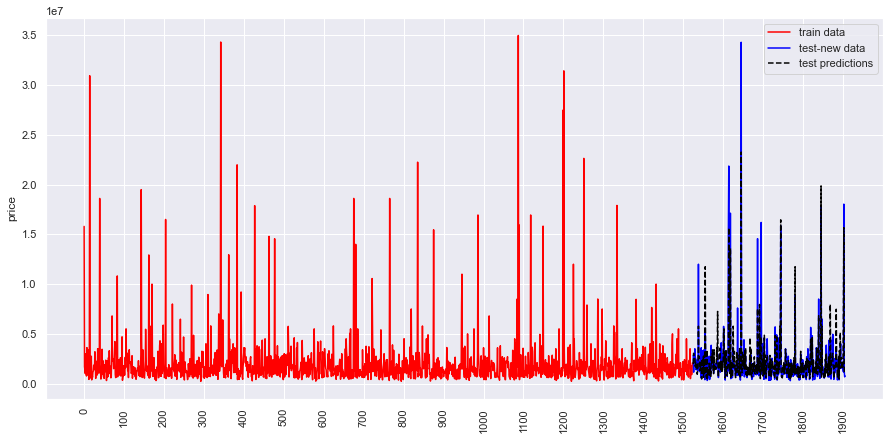

In [87]:
fig, ax = plt.subplots()

p1 = sns.lineplot(x=range(0,len(X_train)), y=Y_train, color='red', label='train data')

p2 = sns.lineplot(x=range(len(X_train)+1, len(X_train)+1+len(Y_new) ), y=Y_new, color='blue', label='test-new data')

p3 = sns.lineplot(x=range(len(X_train)+1, len(X_train)+1+len(Y_new) ), y=knn_regression.predict( X_new ), color='black', linestyle='--', label='test predictions')

p1.set_xticks(np.arange(0 , len(X_train)+1+len(Y_new) , 100))

plt.setp(p1.get_xticklabels(), rotation=90)

plt.show()

# plt.title("Weekly Time Series",  fontsize = 17)

# ax.axvspan(91, 98, color='orange', alpha=0.13) # last eight weeks

#fig.savefig('p11.jpg', format='jpg', dpi=1200)

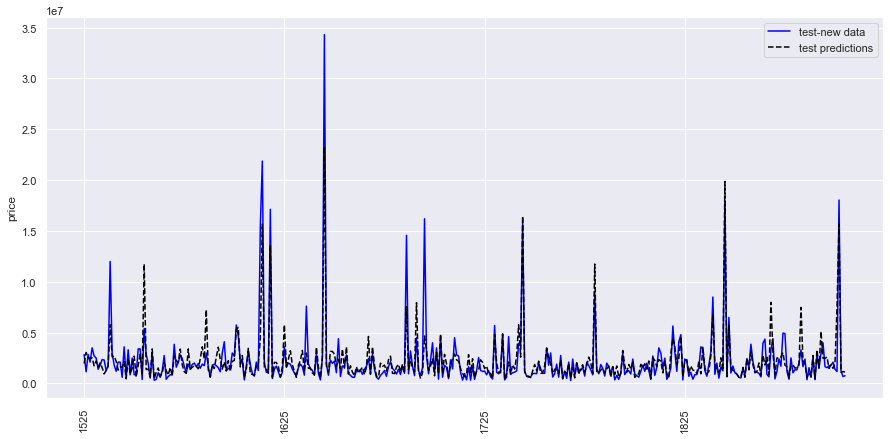

In [92]:
fig, ax = plt.subplots()

# p1 = sns.lineplot(x=range(0,len(X_train)), y=Y_train, color='red', label='train data')

p2 = sns.lineplot(x=range(len(X_train)+1, len(X_train)+1+len(Y_new) ), y=Y_new, color='blue', label='test-new data')

p3 = sns.lineplot(x=range(len(X_train)+1, len(X_train)+1+len(Y_new) ), y=knn_regression.predict( X_new ), color='black', linestyle='--', label='test predictions')

p2.set_xticks(np.arange(len(X_train)+1, len(X_train)+1+len(Y_new) , 100))

plt.setp(p2.get_xticklabels(), rotation=90)

plt.show()

# plt.title("Weekly Time Series",  fontsize = 17)

# ax.axvspan(91, 98, color='orange', alpha=0.13) # last eight weeks

#fig.savefig('p11.jpg', format='jpg', dpi=1200)